# Επισκόπηση Εργασίας

Στην παρούσα εργασία μελετάται η δημιουργία ενός **classifier** για την ταξινόμηση **tweets** χρηστών αεροπορικής εταιρείας σε τρεις ετικέτες (**labels**): **αρνητικό**, **ουδέτερο**, **θετικό**.

Αρχικά η προσπάθεια έγινε σε **Jupyter Notebook** τοπικά· ωστόσο, λόγω του μεγέθους των μοντέλων και των αυξημένων υπολογιστικών απαιτήσεων, η υλοποίηση μεταφέρθηκε στο **Google Colab**. Χωρίς το Colab, η εκτέλεση σε πολλαπλά μοντέλα δεν θα ήταν εφικτή εντός χρόνου/πόρων.

---

## Μοντέλα & Πειραματισμοί

Πραγματοποιήθηκαν πειράματα σε τρία διαφορετικά προεκπαιδευμένα μοντέλα:

- **BERT (bert-base-uncased)**
- **RoBERTa (roberta-base)**
- **BERTweet (vinai/bertweet-base)** — παραλλαγή προσαρμοσμένη ειδικά για tweets

Για κάθε μοντέλο, τα πειράματα **επαναλήφθηκαν** με διαφορετικό βαθμό **unfreezing** στα layers:

1. **Μόνο ο classifier** (παγωμένος ο encoder)
2. **Unfreeze έως layer-11**
3. **Unfreeze έως layer-10**

> Για λόγους πληρότητας και μεγέθους αναφοράς, **στη ροή θα παρουσιαστεί αναλυτικά μόνο το BERT (bert-base-uncased)**. Θα παρατεθούν, όμως, **confusion matrices** και τελικά αποτελέσματα και για τα άλλα δύο μοντέλα.  
> Επιπλέον, τα αποτελέσματα με **unfreeze layer-10** δεν διέφεραν ουσιαστικά από το **layer-11** και **δεν** παρουσιάζονται αναλυτικά.

---

## Προεπεξεργασία Δεδομένων

Δεν εφαρμόστηκε επιπλέον **προεπεξεργασία** πέρα από τη χρήση των **tokenizers** που αντιστοιχούν σε κάθε μοντέλο, ώστε τα δεδομένα να εισαχθούν σωστά στη διαδικασία εκπαίδευσης.

---

## Ροή Εργασίας (στο Colab)

1. **Εγκατάσταση** των απαραίτητων βιβλιοθηκών.  
2. **Ορισμός** βοηθητικών συναρτήσεων που θα χρησιμοποιηθούν στη ροή (φόρτωση δεδομένων, tokenization, training/evaluation).  
3. **Εκτέλεση** των μοντέλων σύμφωνα με τα παραπάνω σενάρια unfreezing.  
4. **Συγκέντρωση αποτελεσμάτων** και **παρατηρήσεων**.

> Στο τέλος της εργασίας παρουσιάζονται τα βασικά **αποτελέσματα** (μετρικές) και οι **confusion matrices** για τη σύγκριση μεταξύ των μοντέλων.

---

# Εγκατάσταση πακέτων για fine-tuning Transformers

Για να τρέξει το notebook, εγκαταστάθηκαν τα βασικά πακέτα:

```bash
!pip -q install "torch>=2.2" "transformers>=4.44.0" "datasets>=2.20.0" "scikit-learn>=1.3" matplotlib pandas numpy

In [4]:
# Βασικά πακέτα για fine-tuning Transformers
!pip -q install --upgrade pip
!pip -q install "torch>=2.2" "transformers>=4.44.0" "datasets>=2.20.0" "scikit-learn>=1.3" matplotlib pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.1 MB/s eta 0:00:00


In [7]:
# --- Βασικές βιβλιοθήκες ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datasets import Dataset

# --- Scikit-learn ---
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score, classification_report

from transformers import (
    AutoTokenizer, BertTokenizer, BertForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback, DataCollatorWithPadding
)

from google.colab import drive, files

import os

# --- Για εξαγωγή σε pdf ---
from matplotlib.backends.backend_pdf import PdfPages

# --- Ρυθμίσεις εμφάνισης pandas ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

## Σύνδεση Google Drive στο Colab

Για **read/write** αρχεία από το Drive μέσα στο notebook:

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


## Δημιουργία φακέλου εργασίας στο Google Drive

Ορίζουμε έναν φάκελο εργασίας μέσα στο Drive και αλλάζουμε τον τρέχοντα κατάλογο εκεί, ώστε όλα τα checkpoints/outputs να αποθηκεύονται μόνιμα.


In [8]:
# Δημιουργία φακέλου εργασίας για αυτό το notebook
work_dir = "/content/drive/MyDrive/bert_tweets_project"
os.makedirs(work_dir, exist_ok=True)

# Αλλαγή τρέχοντος φακέλου σε αυτόν
os.chdir(work_dir)

print("Working directory:", os.getcwd())

Working directory: /content/drive/MyDrive/bert_tweets_project


### Συνάρτηση: `load_data`

**Σκοπός:**  
Φορτώνει δεδομένα από αρχείο (CSV/Excel) ή από ενσωματωμένο dataset του `sklearn`.

**Τι κάνει:**  
- Αν source = `'file'`: επιστρέφει `(df, None)` από `.csv` ή `.xls/.xlsx`  
- Αν source = `'sklearn'`: επιστρέφει `(df, target)` από dataset του `sklearn`  
- Σε Excel εμφανίζει διαθέσιμα sheets αν δεν δοθεί `sheet_name`  
- Εκτυπώνει πληροφορίες για το σχήμα του dataset

**Parameters:**  
- `source : str` → `'file'` (default) ή `'sklearn'`  
- `filepath : str or None` → διαδρομή αρχείου (για source='file')  
- `dataset_func : callable or None` → π.χ. `load_iris` (για source='sklearn')  
- `sheet_name : str or None` → όνομα φύλλου Excel  

**Returns:**  
- `df : pd.DataFrame` → τα δεδομένα  
- `target : np.ndarray or None` → ετικέτες στόχου (μόνο για sklearn datasets)  

In [9]:
def load_data(source='file', filepath=None,  dataset_func=None, sheet_name=None):
    """
    Φόρτωση δεδομένων από αρχείο (CSV/Excel) ή από ενσωματωμένο dataset του sklearn.

    Parameters
    source : str, optional
        'file' για τοπικό αρχείο (default) ή 'sklearn' για dataset του sklearn
    filepath : str or None
        Διαδρομή αρχείου όταν source='file'. Υποστηρίζει .csv, .xls, .xlsx
    dataset_func : callable or None
        Συνάρτηση από sklearn.datasets (π.χ. load_iris) όταν source='sklearn'
    sheet_name : str or None
        Όνομα φύλλου Excel (χρειάζεται μόνο για .xls/.xlsx)

    Returns
    tuple
        (df, target) όπου:
        df : pd.DataFrame με τα δεδομένα
        target : np.ndarray ή None με ετικέτες στόχου (για sklearn datasets)
    """
    if source == 'file':
        if not filepath:
            print("\nΠαρακαλώ δώσε filepath για CSV.")
            return None, None
        try:
            if filepath.endswith('.csv'):
                try:
                    df = pd.read_csv(filepath, encoding="utf-8")
                    print("\nDataset φορτώθηκε από CSV αρχείο:", df.shape)
                except UnicodeDecodeError:
                    df = pd.read_csv(filepath, encoding="utf-8-sig")
                    print("\nDataset φορτώθηκε από CSV αρχείο:", df.shape)
                return df, None
            elif filepath.endswith(('.xls', '.xlsx')):
                if sheet_name is None:
                    # εμφάνιση διαθέσιμων φύλλων (sheets) για επιλογή
                    xls = pd.ExcelFile(filepath)
                    print("\nΔιαθέσιμα φύλλα εργασίας (sheets):", xls.sheet_names)
                    print("Χρησιμοποίησε το όρισμα sheet_name για να διαλέξεις φύλλο.")
                    return None, None
                else:
                    df = pd.read_excel(filepath, sheet_name=sheet_name)
                    print("\n Dataset φορτώθηκε από XLS/XLSX αρχείο:", df.shape)
                    return df, None
        except Exception as e:
            print("\nΣφάλμα κατά το διάβασμα του αρχείου:", e)
            return None, None

    elif source == 'sklearn':
        if not dataset_func:
            print("\nΠαρακαλώ δώσε συνάρτηση π.χ. load_iris για φόρτωση sklearn dataset.")
            return None, None
        try:
            dataset = dataset_func()
            df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
            target = dataset.target
            print(f"\nDataset φορτώθηκε από sklearn ({dataset_func.__name__}):", df.shape)
            return df, target
        except Exception as e:
            print(f"\nΣφάλμα κατά το φόρτωμα του Dataset:", e)
            return None, None

    else:
        print("\nΜη έγκυρη επιλογή source. Δοκίμασε: 'file' ή 'sklearn'.")
        return None, None

### Συνάρτηση: `inspect_data`

**Σκοπός:**  
Γρήγορη επισκόπηση ενός `DataFrame`.

**Τι κάνει:**  
- Εμφανίζει σχήμα (γραμμές, στήλες)  
- Τύπους δεδομένων (`info()`)  
- Πρώτες γραμμές (`head()`)  
- Περιγραφικά στατιστικά (`describe()`)  
- Έλεγχο για NaN τιμές  
- Αν δοθεί `target_column`: εμφανίζει κατανομή τιμών (counts + ποσοστά)  

**Parameters:**  
- `df : pd.DataFrame` → το DataFrame προς ανάλυση  
- `target_column : str, optional` → στήλη με τις ετικέτες στόχου, αν υπάρχει  

**Returns:**  
- Δεν επιστρέφει κάτι, απλά τυπώνει πληροφορίες  

In [10]:
def inspect_data(df, target_column=None):
    """
    Γρήγορη επισκόπηση ενός DataFrame.

    Εμφανίζει:
    - Σχήμα (γραμμές, στήλες)
    - Τύπους δεδομένων και πλήθος NaN
    - Πρώτες γραμμές (head)
    - Περιγραφικά στατιστικά (describe)
    - Αν δοθεί target_column: κατανομή τιμών (counts και ποσοστά)

    Parameters
    df : pd.DataFrame
        Το DataFrame προς ανάλυση.
    target_column : str, optional
        Στήλη στόχου (π.χ. για ταξινόμηση). Αν υπάρχει, εμφανίζεται η κατανομή της.
    """
    print(f"\nΣχήμα DataFrame: {df.shape}")
    print("\nΠληροφορίες DataFrame:")
    df.info()
    print("\nΠρώτες 5 γραμμές:")
    print(df.head())
    print("\nΠεριγραφικά στατιστικά:")
    print(df.describe())
    print("\nΈλεγχος για NaN:")
    print(df.isna().sum())

    if target_column is not None and target_column in df.columns:
        print(f"\nΚατανομή Target labels ({target_column}):")
        print(df[target_column].value_counts())
        print("\nΚατανομή σε ποσοστά:")
        print(df[target_column].value_counts(normalize=True) * 100)

## Συνάρτηση: `plot_confusion_matrices`

Η συνάρτηση αυτή σχεδιάζει δύο confusion matrices **δίπλα-δίπλα** για την αξιολόγηση ενός μοντέλου ταξινόμησης:

1. **Counts matrix** (αριστερά): δείχνει τον απόλυτο αριθμό προβλέψεων ανά κατηγορία.  
   Παράδειγμα: στη γραμμή *neg* και στήλη *pos* = 25 σημαίνει ότι 25 αρνητικά tweets ταξινομήθηκαν λανθασμένα ως θετικά.  

2. **Normalized matrix** (δεξιά): κάθε γραμμή κανονικοποιείται σε ποσοστά (row-wise).  
   Έτσι μπορούμε να δούμε την απόδοση του μοντέλου ανά κλάση ανεξάρτητα από το μέγεθος της κλάσης.  
   Παράδειγμα: αν στη γραμμή *neu* και στήλη *neu* υπάρχει 0.82, σημαίνει ότι το 82% των ουδέτερων tweets ταξινομήθηκαν σωστά.

### Χρήση
```python
y_true, y_pred = get_preds(model, test_loader)
plot_confusion_matrices(y_true, y_pred, ["neg", "neu", "pos"], title_prefix="BiLSTM-W2V")

In [11]:
def plot_confusion_matrices(y_true, y_pred, class_names, title_prefix="Model"):
    """
    Σχεδιάζει confusion matrix σε δύο μορφές (δίπλα-δίπλα):
    - Counts (απόλυτοι αριθμοί)
    - Normalized (ποσοστά ανά γραμμή)

    Parameters
    ----------
    y_true : array-like
        Πραγματικές ετικέτες (ground truth).
    y_pred : array-like
        Προβλεπόμενες ετικέτες από το μοντέλο.
    class_names : list of str
        Ονόματα κλάσεων για εμφάνιση στους άξονες.
    title_prefix : str, optional
        Πρόθεμα για τους τίτλους των plots (default: "Model").

    Returns
    -------
    None
        Εμφανίζει τα confusion matrices με matplotlib.
    """
    labels = list(range(len(class_names)))

    # Υπολογισμός confusion matrices
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    # Plot δίπλα-δίπλα
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # 1) Counts
    im1 = axes[0].imshow(cm, cmap="Blues")
    axes[0].set_xticks(labels); axes[0].set_yticks(labels)
    axes[0].set_xticklabels(class_names); axes[0].set_yticklabels(class_names)
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
    axes[0].set_title(f"{title_prefix} (counts)")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, str(cm[i, j]), ha="center", va="center", color="black")
    fig.colorbar(im1, ax=axes[0])

    # 2) Normalized
    im2 = axes[1].imshow(cm_norm, cmap="Blues")
    axes[1].set_xticks(labels); axes[1].set_yticks(labels)
    axes[1].set_xticklabels(class_names); axes[1].set_yticklabels(class_names)
    axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
    axes[1].set_title(f"{title_prefix} (normalized)")
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            axes[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", color="black")
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

# Συνάρτηση: `tokenize_text`

## Σκοπός
Μετατροπή κειμένων σε tokens με χρήση `tokenizer`, με **δυναμικό padding**.

## Τι κάνει
- Θέτει `max_length = 64` ως ανώτατο όριο για το sequence length  
- Εφαρμόζει truncation αν κάποιο κείμενο ξεπερνά τα 64 tokens  
- Δεν κάνει padding σε αυτό το σημείο → το padding εφαρμόζεται **δυναμικά από τον data collator**  
- Ο data collator κοιτάει το μεγαλύτερο sequence μέσα σε κάθε batch.  
  - Αν το μεγαλύτερο sequence είναι μικρότερο από 64, τότε όλα τα sequences του batch «κόβονται» σε αυτό το μήκος  
  - Έτσι χρησιμοποιείται **λιγότερο padding**, με αποτέλεσμα πιο αποδοτική (γρηγορότερη) εκπαίδευση  

## Parameters
- `data : iterable` → συλλογή κειμένων προς tokenization  
- `tokenizer : transformers.PreTrainedTokenizer` → tokenizer Hugging Face  
- `max_length : int, optional` → μέγιστο μήκος tokens (προεπιλογή: 64)  

## Returns
- `dict` → λεξικό με tokenized data (input_ids, attention_mask, κ.λπ.)  

In [12]:
def tokenize_text(data, tokenizer, max_length=64):
    """
    Tokenizes a collection of texts using a Hugging Face tokenizer,
    με δυναμικό padding που εφαρμόζεται από τον data collator.

    Parameters
    ----------
    data : iterable
        Συλλογή από κείμενα προς tokenization.
    tokenizer : transformers.PreTrainedTokenizer
        Ο tokenizer της Hugging Face.
    max_length : int, optional, default=64
        Μέγιστο μήκος ακολουθίας σε tokens.
        Τα μεγαλύτερα κείμενα κόβονται (truncation).
        Το padding δεν γίνεται εδώ, αλλά δυναμικά από τον collator.

    Returns
    -------
    dict
        Λεξικό που περιέχει τα tokenized δεδομένα (π.χ. input_ids, attention_mask).
    """
    # Εφαρμόζουμε truncation σε max_length tokens
    # ΔΕΝ βάζουμε padding εδώ -> γίνεται δυναμικά στο collator
    # Ο collator προσαρμόζει το padding στο μεγαλύτερο sequence του batch
    # Έτσι μειώνεται το άχρηστο padding και η εκπαίδευση γίνεται ταχύτερη
    return tokenizer(
        list(data),
        truncation=True,
        max_length=max_length,
        padding=False,   # <-- δυναμικό padding στο collator
    )

##### `Η παρακάτω συναρτηση ειναι αυτούσια από το παράδειγμα`
### Συνάρτηση: `plot_losses_to_pdf`

**Σκοπός:**  
Σχεδιάζει τις καμπύλες **training** και **validation loss** και αποθηκεύει το γράφημα σε PDF.

**Τι κάνει:**  
- Δημιουργεί γραφική παράσταση με `matplotlib`  
- Σχεδιάζει τις καμπύλες train/val loss ανά epoch  
- Αποθηκεύει το γράφημα σε PDF (`PdfPages`)  
- Προαιρετικά εμφανίζει το γράφημα στην οθόνη (`show_plot=True`)  

**Parameters:**  
- `train_losses : list` → training loss ανά εποχή  
- `val_losses : list` → validation loss ανά εποχή  
- `pdf_filename : str` → όνομα αρχείου PDF (default: 'training_validation_losses.pdf')  
- `figsize : tuple` → μέγεθος σχήματος (default: (8, 6))  
- `show_plot : bool` → αν εμφανίζεται το γράφημα στην οθόνη (default=False)  

**Returns:**  
- `str` → το όνομα του PDF αρχείου που δημιουργήθηκε

In [13]:
def plot_losses_to_pdf(
        train_losses,
        val_losses,
        pdf_filename='training_validation_losses.pdf',
        figsize=(8, 6),
        show_plot=False,
):
    """
    Plots the training and validation losses,
    and saves the figure to a PDF file.

    Args:
        train_losses (list): Training loss per epoch.
        val_losses (list): Validation loss per epoch.
        pdf_filename (str): Name/path of the PDF file to save.
        figsize (tuple): Size of the figure (width, height in inches).
        show_plot (bool): Show the plot or not.
    Return:
        pdf_filaname (str): The filename of the generated pdf.
    """
    # Create a figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)

    # Plot the train/val curves
    ax.plot(train_losses, label="Train Loss")
    ax.plot(val_losses, label="Val Loss")

    ax.set_title("Training & Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

    # Save the current figure into a PDF
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig(fig)  # Save the figure in the PDF

    # Optionally display in interactive environments
    if show_plot:
        plt.show()
    # Close the figure to free memory
    plt.close(fig)
    print(f"The learning curves are generated in pdf: {pdf_filename}")
    return pdf_filename

## Μεταφόρτωση & Φόρτωση Δεδομένων

Ανεβάζω το αρχείο `Tweets.csv` από τον υπολογιστή μου με `files.upload()` και στη συνέχεια το φορτώνω στο notebook με τη βοηθητική συνάρτηση `load_data` (π.χ. `filepath="Tweets.csv"`)

In [15]:
# Μεταφόρτωση του αρχείου Tweets.csv από τον τοπικό υπολογιστή στο περιβάλλον Colab
uploaded = files.upload()

# Φόρτωση του ανεβασμένου αρχείου CSV στο DataFrame μέσω της βοηθητικής συνάρτησης load_data
df,_ = load_data(source='file', filepath='Tweets.csv',  dataset_func=None, sheet_name=None)

Saving Tweets.csv to Tweets (1).csv

Dataset φορτώθηκε από CSV αρχείο: (14640, 15)


In [16]:
# Επιλογή μόνο των απαραίτητων στηλών (κείμενο, ετικέτα) και απομάκρυνση εγγραφών με κενές τιμές
df = df[["text", "airline_sentiment"]].dropna()

In [17]:
# Αρχική επισκόπηση του DataFrame (διαστάσεις, τύποι στηλών, δείγματα/ελλείπουσες τιμές)
inspect_data(df, target_column=None)


Σχήμα DataFrame: (14640, 2)

Πληροφορίες DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               14640 non-null  object
 1   airline_sentiment  14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB

Πρώτες 5 γραμμές:
                                                                                                                             text airline_sentiment
0                                                                                             @VirginAmerica What @dhepburn said.           neutral
1                                                        @VirginAmerica plus you've added commercials to the experience... tacky.          positive
2                                                         @VirginAmerica I didn't today... Must mean I need to take another trip!           neutra

In [18]:
# Απομάκρυνση διπλότυπων εγγραφών, ώστε κάθε tweet να εμφανίζεται μία μόνο φορά στο σύνολο
df = df.drop_duplicates()

# Εμφάνιση των νέων διαστάσεων (γραμμές, στήλες) μετά την απομάκρυνση
print("Νέο σχήμα DataFrame:", df.shape)

Νέο σχήμα DataFrame: (14452, 2)


## Κωδικοποίηση ετικετών (labels)

Μετατρέπουμε την στήλη `airline_sentiment` σε ακέραιους δείκτες με `LabelEncoder` και αποθηκεύουμε το αποτέλεσμα στη στήλη `label`.  
Εκτυπώνουμε επίσης τη σειρά των τάξεων, ώστε να γνωρίζουμε τη χαρτογράφηση `label ↔ id` (χρήσιμη για `id2label/label2id` στον Trainer).

In [19]:
# Κωδικοποίηση της στήλης 'airline_sentiment' σε ακέραια ids με LabelEncoder
le = LabelEncoder()
df["label"] = le.fit_transform(df["airline_sentiment"])

print("Classes (με τη σειρά των ids):", list(le.classes_))
print("Αριθμός κλάσεων:", len(le.classes_))

Classes (με τη σειρά των ids): ['negative', 'neutral', 'positive']
Αριθμός κλάσεων: 3


## Διαχωρισμός συνόλων εκπαίδευσης/επαλήθευσης/ελέγχου

Διαχωρίζουμε το dataset σε **80% train**, **10% validation**, **10% test** με **stratify** ως προς τη μεταβλητή στόχο (`label`) ώστε να διατηρηθούν οι αναλογίες κλάσεων.  
Ο διαχωρισμός γίνεται σε δύο βήματα: αρχικά 80/20 (train/temp) και έπειτα το 20% χωρίζεται ισομερώς σε validation/test. Χρησιμοποιούμε σταθερό `random_state` για αναπαραγωγιμότητα.

In [20]:
# 1) Πρώτο split: 80% train, 20% temp (με stratify για διατήρηση αναλογιών κλάσεων)
train_X, temp_X, train_y, temp_y = train_test_split(
    df["text"], df["label"],
    test_size=0.20,
    random_state=42,
    stratify=df["label"]
)

# 2) Δεύτερο split στο temp: 50% validation, 50% test → συνολικά 10% val, 10% test
val_X, test_X, val_y, test_y = train_test_split(
    temp_X, temp_y,
    test_size=0.50,
    random_state=42,
    stratify=temp_y
)

# Έλεγχος διαστάσεων των συνόλων
print("Train:", train_X.shape, train_y.shape)
print("Val:  ", val_X.shape,   val_y.shape)
print("Test: ", test_X.shape,  test_y.shape)

Train: (11561,) (11561,)
Val:   (1445,) (1445,)
Test:  (1446,) (1446,)


## Tokenizer BERT (bert-base-uncased)

Φορτώνουμε τον προεκπαιδευμένο **BertTokenizer** για το checkpoint `bert-base-uncased`.  
Με `do_basic_tokenize=True` εφαρμόζεται αρχικά **basic tokenization** (διαχωρισμός σημείων στίξης, lowercasing κ.λπ.) πριν από το **WordPiece**.  
Ο tokenizer μετατρέπει τα κείμενα σε υπολέξεις (subwords) και, κατά την κωδικοποίηση, παράγει `input_ids`, `attention_mask` και ειδικά tokens όπως `[CLS]`, `[SEP]`.

### Τι είναι το WordPiece (σύντομα)
- **Subword tokenization**: σπάει άγνωστες ή σπάνιες λέξεις σε κομμάτια που υπάρχουν στο λεξιλόγιο (π.χ. `unbelievable → un ##believ ##able`).  
- **Κάλυψη OOV**: ελαχιστοποιεί τα out-of-vocabulary, ώστε το μοντέλο να μπορεί να χειριστεί νέες/σπάνιες λέξεις.    
- **Συμβατικό πρόθεμα `##`**: δηλώνει ότι το υποκομμάτι **συνεχίζει** μια λέξη.

In [21]:
bert_Tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased",
    do_basic_tokenize=True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Εφαρμογή tokenization σε train/validation/test

Εφαρμόζουμε τον ίδιο **BERT tokenizer** στα τρία υποσύνολα (**train**, **validation**, **test**) με κοινό `max_length=64`, ώστε όλες οι ακολουθίες να έχουν ενιαίο μήκος.  
Η συνάρτηση `tokenize_text(...)` επιστρέφει τα απαραίτητα tensors (π.χ. `input_ids`, `attention_mask` και, όπου απαιτείται, `token_type_ids`) εφαρμόζοντας **truncation** σε μεγαλύτερα tweets και **padding** στα μικρότερα.

In [22]:
# 3) Εφαρμογή σε train / val / test
bert_train = tokenize_text(train_X, bert_Tokenizer, max_length=64)
bert_val   = tokenize_text(val_X,   bert_Tokenizer, max_length=64)
bert_test  = tokenize_text(test_X,  bert_Tokenizer, max_length=64)



## Φόρτωση BERT + απλός νευρωνικός classifier

Φορτώνουμε το `bert-base-uncased` και πάνω του βάζουμε **έναν απλό νευρωνικό classifier** για 3 κατηγορίες (αρνητικό, ουδέτερο, θετικό).  
Έπειτα στέλνουμε το μοντέλο σε **GPU** αν υπάρχει, αλλιώς σε **CPU**.

In [32]:
# BERT + απλός νευρωνικός classifier για 3 κατηγορίες
model_name = "bert-base-uncased"
bert_model_un1 = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Χρήση GPU αν υπάρχει, αλλιώς CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_un1.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Πάγωμα μοντέλου — εκπαίδευση μόνο του classifier

Επιλέγουμε να εκπαιδεύσουμε **μόνο** τον classifier και να «παγώσουμε» όλα τα υπόλοιπα βάρη του BERT.  
Αυτό βοηθά για γρήγορο fine-tuning ή όταν τα δεδομένα είναι περιορισμένα. Παρακάτω ορίζουμε ποια μέρη μένουν εκπαιδεύσιμα και εκτυπώνουμε λίστες με τις **εκπαιδεύσιμες** και τις **παγωμένες** παραμέτρους για έλεγχο.

In [33]:
# unfreeze only the classification head
trainable_parameters = ['classifier']
for name, param in bert_model_un1.named_parameters():
    param.requires_grad = any(name.startswith(prefix) for prefix in trainable_parameters)

print("The unfreezed layers in the transformer model")
for name, param in bert_model_un1.named_parameters():
    if param.requires_grad:
        print(name)
print("--------------------------------------------------------------")
# print the names of NOT trainable parameters
print("The freezed layers in the transformer model")
for name, param in bert_model_un1.named_parameters():
    if not param.requires_grad:
        print(name)

The unfreezed layers in the transformer model
classifier.weight
classifier.bias
--------------------------------------------------------------
The freezed layers in the transformer model
bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weig

## Δημιουργία HuggingFace `Dataset` για train / val / test

Μετατρέπουμε τα **tokenized** δεδομένα (από τον BERT tokenizer) σε αντικείμενα `Dataset`, ώστε να τα δεχτεί ο `Trainer`.  
Χρησιμοποιούμε τα κλειδιά `input_ids`, `attention_mask` και τη στήλη στόχου ως `labels` (σε `numpy` array).

In [34]:
train_ds = Dataset.from_dict({
    "input_ids": bert_train["input_ids"],
    "attention_mask": bert_train["attention_mask"],
    "labels": train_y.to_numpy()     # όχι y_train_t
})

val_ds = Dataset.from_dict({
    "input_ids": bert_val["input_ids"],
    "attention_mask": bert_val["attention_mask"],
    "labels": val_y.to_numpy()       # όχι y_val_t
})

test_ds = Dataset.from_dict({
    "input_ids": bert_test["input_ids"],
    "attention_mask": bert_test["attention_mask"],
    "labels": test_y.to_numpy()      # όχι y_test_t
})

## Data collator (δυναμικό padding)

Ο `DataCollatorWithPadding` κάνει **δυναμικό padding** ανά batch: προσαρμόζει το μήκος κάθε δείγματος στο μήκος του μεγαλύτερου μέσα στο ίδιο batch. Έτσι αποφεύγουμε άσκοπο padding και η εκπαίδευση είναι πιο αποδοτική.

In [35]:
data_collator = DataCollatorWithPadding(tokenizer=bert_Tokenizer, padding="longest")

In [36]:
print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))
print("Test size:", len(test_ds))

Train size: 11561
Validation size: 1445
Test size: 1446


## Φάκελος εξόδου (checkpoints / logs)

Ορίζουμε τον φάκελο όπου θα σωθούν τα **checkpoints**, τα **logs** και τα **metrics** για αυτό το run.  
Χρησιμοποιώ ένα σύντομο tag για το σενάριο (π.χ. `un1` = πείραμα unfreezing layer 1).

In [38]:
OUTPUT_DIR = "bert_un1"

## Ρυθμίσεις εκπαίδευσης (TrainingArguments) — σενάριο: «εκπαίδευση μόνο στο classifier»

Σε αυτό το βήμα ορίζουμε τις βασικές παραμέτρους εκπαίδευσης για τον `Trainer`:  
πόσες εποχές θα τρέξουμε, μέγεθος batch, ρυθμό μάθησης, πότε κάνουμε αξιολόγηση/αποθήκευση, ποιο checkpoint κρατάμε κ.λπ.  
Επειδή στο συγκεκριμένο σενάριο **εκπαιδεύουμε μόνο τον classifier** πάνω από το BERT (τα υπόλοιπα βάρη είναι παγωμένα), ρυθμίζουμε κατάλληλα το LR.

**Παρατηρήσεις**
- **Μεγαλύτερο LR (5e-5)**: όταν είναι εκπαιδεύσιμος μόνο ο classifier, μικρά LR οδηγούν σε πολλές εποχές με ελάχιστες βελτιώσεις στο validation. Το 5e-5 βοηθά σε πιο γρήγορη σύγκλιση.
- **Εξοικονόμηση χώρου**: `save_total_limit=3` για να μη γεμίζει ο δίσκος. Στόχος είναι να μένουν τα **δύο τελευταία** checkpoints και το **καλύτερο** (με βάση το validation).
- **Επιλογή «καλύτερου»**: `load_best_model_at_end=True` με `metric_for_best_model="eval_loss"` και `greater_is_better=False`, ώστε να φορτωθεί αυτό με τη **μικρότερη** `eval_loss` στο τέλος.
- **GPU mixed precision**: `fp16=True` αυτόματα όταν υπάρχει CUDA στο Colab, για ταχύτερη εκτέλεση και μικρότερη μνήμη.

In [39]:
# Ρυθμίσεις Trainer για το σενάριο όπου εκπαιδεύουμε μόνο τον classifier
training_args_un1 = TrainingArguments(
    output_dir=OUTPUT_DIR,                # φάκελος για checkpoints/logs/metrics
    num_train_epochs=100,                 # πολλές εποχές: μικρά βήματα βελτίωσης μόνο στον classifier
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,                   # λίγο μεγαλύτερο LR για ταχύτερη σύγκλιση του classifier
    eval_strategy="epoch",                # αξιολόγηση στο τέλος κάθε epoch
    save_strategy="epoch",                # αποθήκευση checkpoint στο τέλος κάθε epoch
    logging_strategy="epoch",             # logging ανά epoch (συνοπτικό και καθαρό)
    save_total_limit=3,                   # κράτα λίγα checkpoints (π.χ. 2 τελευταία + το καλύτερο)
    load_best_model_at_end=True,          # στο τέλος φόρτωσε αυτό με το καλύτερο validation metric
    metric_for_best_model="eval_loss",    # κριτήριο «καλύτερου» checkpoint
    greater_is_better=False,              # όσο μικρότερη eval_loss τόσο καλύτερα
    report_to="none",                     # χωρίς εξωτερικά logs (π.χ. wandb/tensorboard)
    seed=42,                              # αναπαραγωγιμότητα
    fp16=torch.cuda.is_available(),       # mixed precision σε GPU (Colab)
    overwrite_output_dir=True             # επίτρεψε overwrite του output_dir σε επανεκτέλεση
)

## Δημιουργία `Trainer` (σενάριο un1)

Στήνουμε τον `Trainer` με τα: **μοντέλο**, **ρυθμίσεις εκπαίδευσης**, **datasets**, **tokenizer** και **data collator**.  
Χρησιμοποιούμε **δυναμικό padding** μέσω `data_collator` και **early stopping** με `patience=4`: αν το validation **δεν βελτιωθεί** για 4 συνεχόμενες αξιολογήσεις (εδώ: 4 epochs, γιατί κάνουμε `eval_strategy="epoch"`), η εκπαίδευση σταματά.  
Το “καλύτερο” checkpoint ορίζεται από το `metric_for_best_model="eval_loss"` (με μικρότερο να είναι το καλύτερο) και φορτώνεται στο τέλος (`load_best_model_at_end=True`).

In [40]:

trainer_un1 = Trainer(
    model=bert_model_un1,                 # BERT + απλός classifier (3 κατηγορίες)
    args=training_args_un1,               # ρυθμίσεις εκπαίδευσης για το σενάριο un1
    train_dataset=train_ds,               # σύνολο εκπαίδευσης (tokenized + labels)
    eval_dataset=val_ds,                  # σύνολο επαλήθευσης για αξιολόγηση ανά epoch
    tokenizer=bert_Tokenizer,             # για αυτόματο padding/truncation/decoding όπου χρειαστεί
    data_collator=data_collator,          # δυναμικό padding ανά batch (πιο αποδοτικό)
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]  # Early stopping: αν δεν βελτιωθεί το validation metric για 4 epochs, σταμάτα.
)

/tmp/ipython-input-3079939809.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_un1 = Trainer(


In [41]:
# Έναρξη εκπαίδευσης
trainer_un1.train()

Epoch,Training Loss,Validation Loss
1,0.927000,0.897384
2,0.890200,0.877293
3,0.874100,0.865952
4,0.863600,0.849920
5,0.854200,0.839554
6,0.844200,0.830013
7,0.833600,0.822777
8,0.827200,0.812012
9,0.820600,0.803141
10,0.813200,0.796568


TrainOutput(global_step=36200, training_loss=0.7269333315685967, metrics={'train_runtime': 1153.9108, 'train_samples_per_second': 1001.897, 'train_steps_per_second': 31.372, 'total_flos': 2.839249644805993e+16, 'train_loss': 0.7269333315685967, 'epoch': 100.0})

## Σύνοψη εκπαίδευσης — μόνο ο classifier (unfreeze)

Παρακάτω φαίνονται τα **πρώτα 5** και τα **τελευταία 5** epochs για **BERT**, **RoBERTa** και **BERTweet** (εκπαιδεύσιμος μόνο ο classifier).

- **BERT**: Έτρεξε **όλα τα 100 epochs** (δεν ενεργοποιήθηκε early stopping). Η **μείωση του validation loss** ήταν πολύ **αργή** και σταδιακή μετά τα πρώτα epochs (π.χ. ~0.84 → ~0.65).
- **RoBERTa**: Ξεκίνησε με **χαμηλότερα** train/validation losses και **σταμάτησε στο epoch 42** με **καλύτερο validation loss ~0.488**.
- **BERTweet**: **Σταμάτησε στο epoch 25**. Είχε από νωρίς καλύτερο validation loss από το RoBERTa και τελικά έφτασε περίπου **~0.470**, δηλαδή **λίγο καλύτερα** από το RoBERTa.

**Συμπέρασμα**: Με εκπαιδεύσιμο μόνο τον classifier, το **BERT** συγκλίνει πιο αργά. **RoBERTa** και **BERTweet** φτάνουν γρηγορότερα σε χαμηλότερο validation loss, με **μικρό προβάδισμα του BERTweet** στο τελικό score — **και αισθητά ταχύτερη σύγκλιση**.

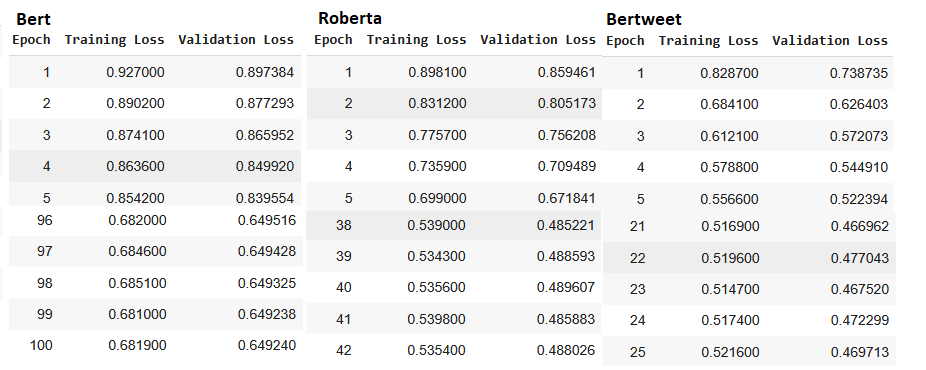

In [44]:
# Δες ποιο ήταν το καλύτερο checkpoint που κράτησε ο Trainer
print("Best metric:", trainer_un1.state.best_metric)
print("Best checkpoint:", trainer_un1.state.best_model_checkpoint)

Best metric: 0.6492376923561096
Best checkpoint: bert_un1/checkpoint-35838


## Αξιολόγηση στο test & συλλογή καμπυλών loss

1) Τρέχουμε `evaluate(test_ds)` για να πάρουμε τα **metrics στο test set**.  
2) Παίρνουμε τα **logs** από τον Trainer και φτιάχνουμε λίστες με:
   - `train_losses`: τιμές training loss (ανά epoch/βήμα όπως καταγράφηκαν),
   - `val_losses`: τιμές validation loss (ανά epoch).
3) Οι δύο λίστες θα χρησιμοποιηθούν αμέσως μετά για το γράφημα:
   `plot_losses_to_pdf(train_losses, val_losses, pdf_filename="loss_curves.pdf", show_plot=True)`  
   ώστε να εμφανιστεί η καμπύλη και να αποθηκευτεί σε PDF

In [46]:
test_metrics = trainer_un1.evaluate(test_ds)
print("Test metrics:", test_metrics)

Test metrics: {'eval_loss': 0.6618267893791199, 'eval_runtime': 0.9913, 'eval_samples_per_second': 1458.641, 'eval_steps_per_second': 46.402, 'epoch': 100.0}


In [49]:
# Πάρε τα logs από το Trainer
logs = trainer_un1.state.log_history

# Φιλτράρουμε μόνο τα entries με eval_loss
train_losses = [entry["loss"] for entry in logs if "loss" in entry and "epoch" in entry]
val_losses   = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]

# ευθυγράμμιση: κρατάμε όσα epochs εκπαιδεύτηκαν
val_losses = val_losses[:len(train_losses)]

print("Train losses:", train_losses)
print("Val losses:", val_losses)

Train losses: [0.927, 0.8902, 0.8741, 0.8636, 0.8542, 0.8442, 0.8336, 0.8272, 0.8206, 0.8132, 0.8077, 0.8012, 0.7956, 0.7909, 0.7828, 0.7808, 0.7788, 0.7735, 0.7709, 0.7631, 0.7622, 0.7576, 0.7558, 0.7523, 0.7463, 0.7481, 0.7438, 0.7418, 0.7394, 0.7369, 0.7321, 0.7312, 0.7321, 0.7305, 0.726, 0.7209, 0.7213, 0.7219, 0.7179, 0.7165, 0.7154, 0.7135, 0.7088, 0.7128, 0.711, 0.7082, 0.7054, 0.709, 0.7043, 0.7042, 0.7007, 0.7004, 0.7009, 0.7011, 0.7016, 0.697, 0.698, 0.6984, 0.6944, 0.6956, 0.6947, 0.6929, 0.6914, 0.6939, 0.6923, 0.6882, 0.6913, 0.69, 0.6913, 0.6892, 0.6906, 0.6898, 0.6895, 0.6898, 0.6854, 0.688, 0.6888, 0.6869, 0.6865, 0.6883, 0.6879, 0.6877, 0.6857, 0.6862, 0.6851, 0.6853, 0.6843, 0.6835, 0.6854, 0.6854, 0.6853, 0.6797, 0.6796, 0.6853, 0.6852, 0.682, 0.6846, 0.6851, 0.681, 0.6819]
Val losses: [0.8973842263221741, 0.8772927522659302, 0.8659519553184509, 0.849919855594635, 0.839554488658905, 0.8300129175186157, 0.8227769136428833, 0.8120123147964478, 0.8031410574913025, 0.796

# Καμπύλες loss & παρατήρηση για overfitting

Οι καμπύλες **RoBERTa** και **BERTweet** είναι **παρόμοιες** με του **BERT**: σταθερή πτώση του `train_loss` και του `val_loss`, μικρή απόσταση μεταξύ τους, και νωρίτερη διακοπή με early stopping (≈42 για RoBERTa, ≈25 για BERTweet).

**Παρατήρηση:** Και στα τρία μοντέλα, με **μονο τον classifier εκπαιδεύσιμο** (encoder παγωμένος), **δεν εμφανίζεται overfitting**· ακόμη κι όταν ενεργοποιείται το early stopping, το χάσμα train–val παραμένει μικρό.

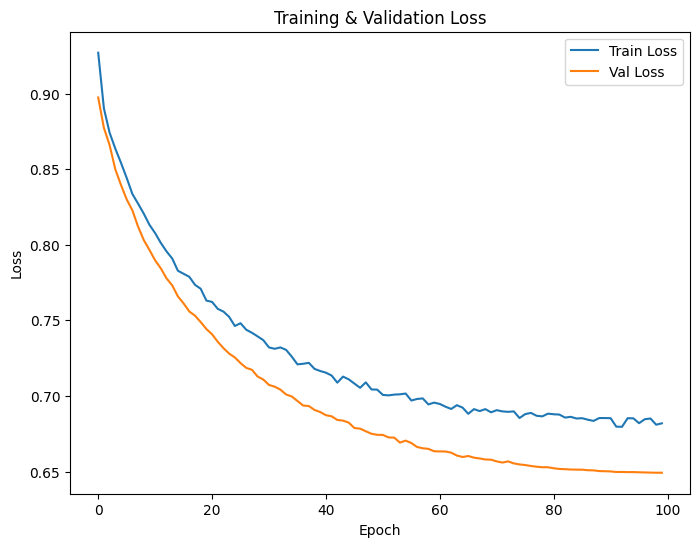

The learning curves are generated in pdf: loss_curves.pdf


'loss_curves.pdf'

In [50]:
# Σχεδίαση και αποθήκευση των καμπυλών train/val loss σε PDF
plot_losses_to_pdf(train_losses, val_losses, pdf_filename="loss_curves.pdf", show_plot=True)

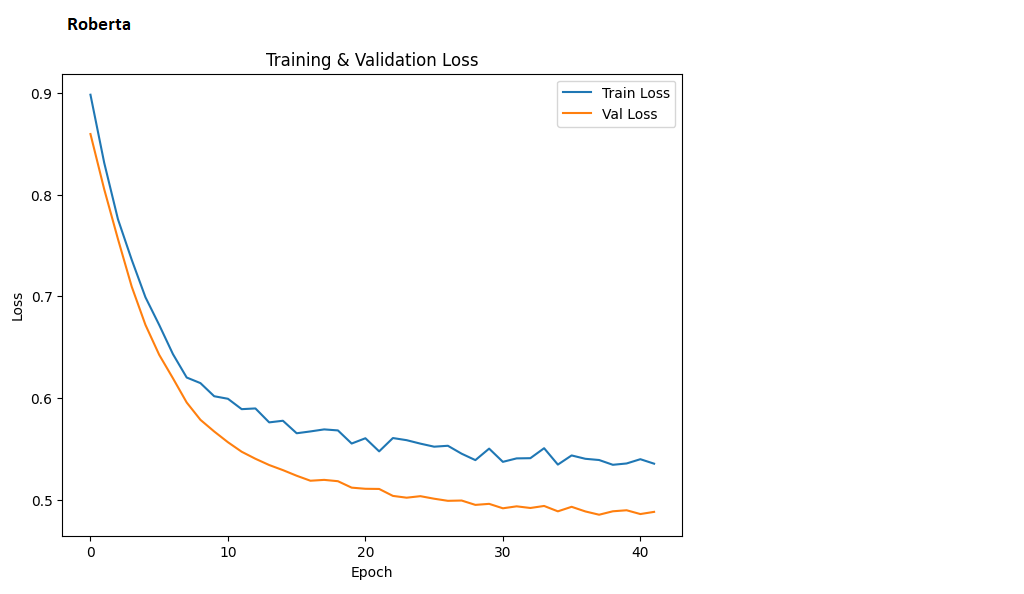

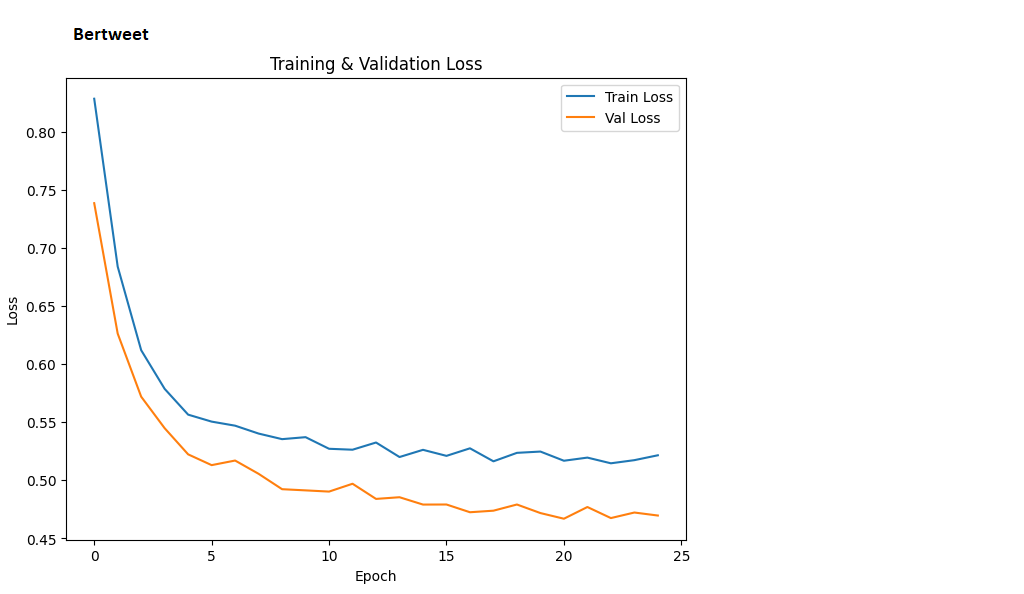

In [52]:
val_metrics = trainer_un1.evaluate(eval_dataset=val_ds)
test_metrics = trainer_un1.evaluate(eval_dataset=test_ds)
print("Validation:", val_metrics)
print("Test:", test_metrics)

Validation: {'eval_loss': 0.6492376923561096, 'eval_runtime': 1.0518, 'eval_samples_per_second': 1373.779, 'eval_steps_per_second': 43.733, 'epoch': 100.0}
Test: {'eval_loss': 0.6618267893791199, 'eval_runtime': 0.9308, 'eval_samples_per_second': 1553.504, 'eval_steps_per_second': 49.42, 'epoch': 100.0}


In [54]:
# Προβλέψεις στο test
pred_out_un1 = trainer_un1.predict(test_ds)
y_pred_un1 = np.argmax(pred_out_un1.predictions, axis=-1)
y_true = np.array(test_y)

acc = accuracy_score(y_true, y_pred_un1)
pr_w, rc_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred_un1, average="weighted", zero_division=0)
pr_m, rc_m, f1_m, _ = precision_recall_fscore_support(y_true, y_pred_un1, average="macro", zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Weighted  P/R/F1: {pr_w:.4f} / {rc_w:.4f} / {f1_w:.4f}")
print(f"Macro     P/R/F1: {pr_m:.4f} / {rc_m:.4f} / {f1_m:.4f}")

# Αναλυτικό report ανά κλάση
print(classification_report(y_true, y_pred_un1, target_names=list(le.classes_), zero_division=0))


Accuracy: 0.7303
Weighted  P/R/F1: 0.7198 / 0.7303 / 0.6940
Macro     P/R/F1: 0.7114 / 0.5595 / 0.5928
              precision    recall  f1-score   support

    negative       0.74      0.96      0.83       909
     neutral       0.64      0.27      0.38       307
    positive       0.75      0.45      0.57       230

    accuracy                           0.73      1446
   macro avg       0.71      0.56      0.59      1446
weighted avg       0.72      0.73      0.69      1446



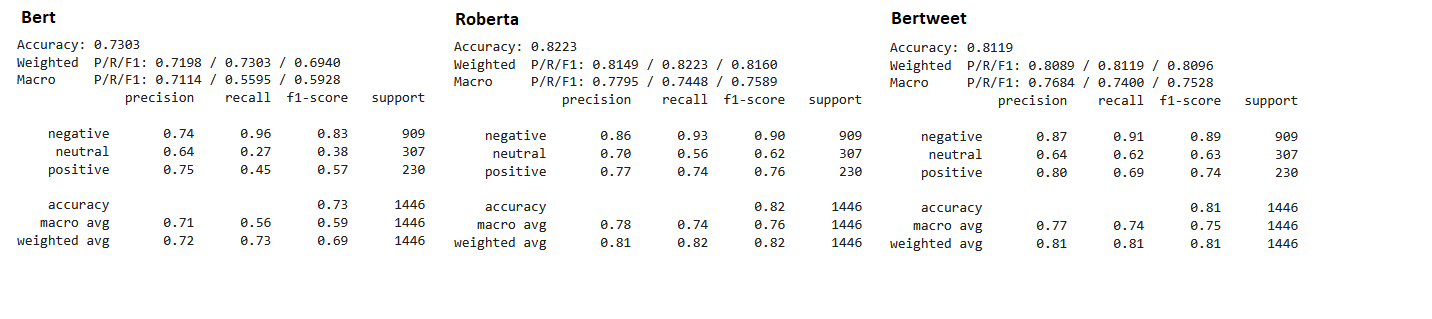

## Σύνοψη αποτελεσμάτων

- **RoBERTa** δίνει την **καλύτερη συνολική επίδοση** (accuracy/F1), με ισορροπημένα scores σε όλες τις κλάσεις.
- **BERTweet** είναι **πολύ κοντά** σε απόδοση στο τέλος και **συγκλίνει ταχύτερα**, πιθανόν λόγω προεκπαίδευσης σε tweets.
- **BERT (uncased)** υπολείπεται κυρίως σε **recall** για τις κλάσεις **neutral** και **positive**, ενώ η **negative** παραμένει υψηλή σε όλα τα μοντέλα.
- Παρά το ότι εκπαιδεύσαμε **μόνο τον classifier**, τα ισχυρά encoders (RoBERTa/BERTweet) φέρνουν καθαρό κέρδος· περισσότερα unfreezed layers πιθανότατα θα βελτίωναν περαιτέρω το neutral/positive.

Η μικρή απόσταση μεταξύ weighted και macro μετρικών σε RoBERTa/BERTweet δείχνει πιο ισόρροπη συμπεριφορά μεταξύ κλάσεων, σε σχέση με το BERT όπου η απόσταση είναι μεγαλύτερη.

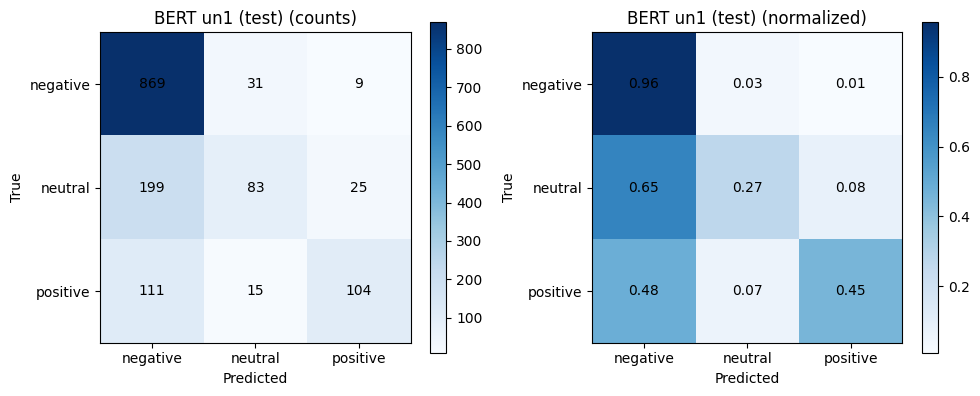

In [57]:
plot_confusion_matrices(y_true, y_pred_un1, class_names=list(le.classes_), title_prefix="BERT un1 (test)")

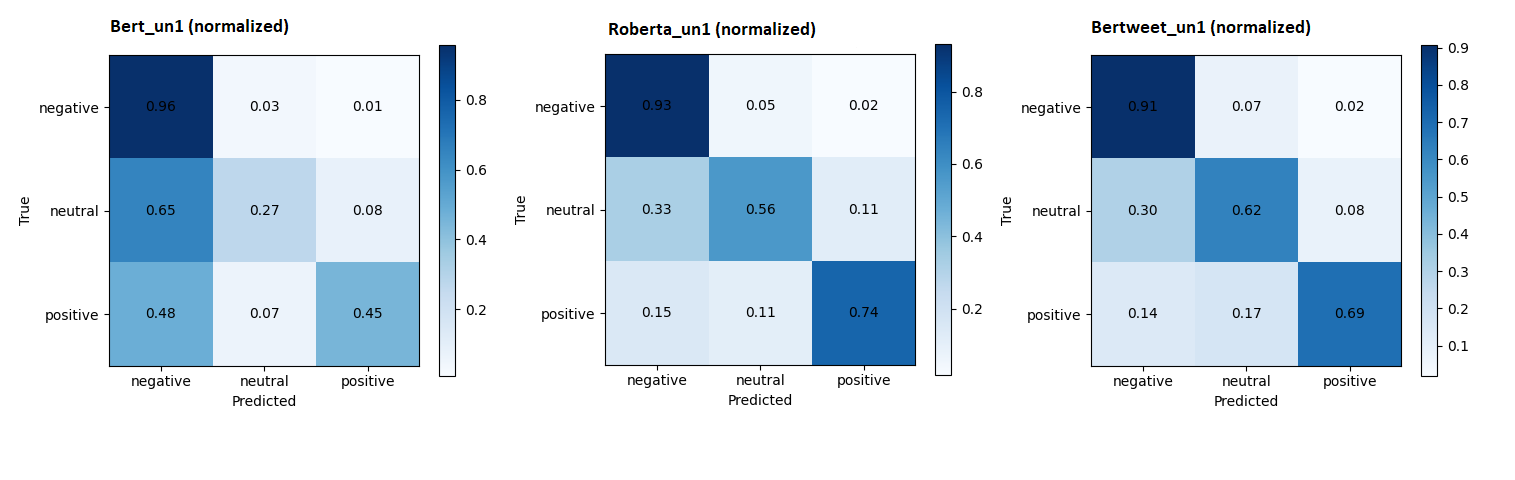

## Confusion Matrices (Normalized) — BERT / RoBERTa / BERTweet

Παραπάνω φαίνονται οι **normalized** confusion matrices για τα τρία μοντέλα (μόνο ο classifier εκπαιδεύσιμος).

**Τι παρατηρούμε:**
- **BERT**: είναι το πιο αδύναμο. Πολύ υψηλή ανάκληση στο *negative*, αλλά πολλά λάθη **neutral → negative** και **positive → negative**.
- **RoBERTa**: πιο ισορροπημένο. Λιγότερες συγχύσεις στις μικρές κλάσεις, αν και το *neutral* παραμένει το πιο δύσκολο.
- **BERTweet**: παρόμοιο με RoBERTa, ελαφρώς καλύτερο στις *neutral/positive*.

**Σύγκριση με προηγούμενη εργασία (RNN-BiLSTM + attention):**
- Το **BERT** αποδίδει **χειρότερα** από το RNN baseline.
- Τα **RoBERTa** και **BERTweet** είναι **λίγο χειρότερα** από το RNN baseline συνολικά.

**Πιθανή εξήγηση:** με **μικρό dataset** και **παγωμένο encoder** (εκπαιδεύεται μόνο ο classifier), η «δύναμη» των Transformers δεν φαίνεται πλήρως. Αν ξεπαγώσουμε περισσότερα layers, αναμένουμε βελτίωση ειδικά για *neutral* και *positive*.

## Unfreeze μόνο του **τελευταίου layer**

Σε αυτό το στάδιο **ανοίγουμε μόνο το τελευταίο layer του encoder** μαζί με τον **classifier**.  

### Τι αλλάζει τώρα
- Εκπαιδεύσιμα βάρη: **`classifier` + τελευταίο encoder layer** (όλα τα υπόλοιπα μένουν frozen).
- Learning rate: `5e-5` → `1e-5`
- Early stopping / logging / save policy: **ίδια** με πριν.

### Ροή (ίδια με πριν)
1. Ορίζουμε ποια ονόματα παραμέτρων θα είναι `requires_grad=True`  
   (π.χ. `classifier` και το τελευταίο layer:  
   BERT → `bert.encoder.layer.11`, RoBERTa/BERTweet → `roberta.encoder.layer.11`).
2. Δημιουργούμε τα `Dataset`/`data_collator` (όπως πριν).
3. Ορίζουμε `TrainingArguments` (ίδια, με μικρότερο LR).
4. Φτιάχνουμε νέο `Trainer` και τρέχουμε `train()`/`evaluate()`.
5. Παίρνουμε τα logs και σχεδιάζουμε τις καμπύλες loss.

## Αρχικοποίηση μοντέλου (fresh start)

Φορτώνουμε **ξανά** το `bert-base-uncased` για να ξεκινήσουμε καθαρά στο νέο σενάριο (unfreeze τελευταίο layer).  
Έτσι **μηδενίζουμε** τυχόν αλλαγές από το προηγούμενο run και κρατάμε μόνο τα προεκπαιδευμένα βάρη.  
Έπειτα το στέλνουμε σε **GPU** αν υπάρχει (αλλιώς **CPU**).

In [60]:
# Αρχικοποίηση του BERT για το νέο σενάριο
bert_model_un2 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Στέλνουμε σε GPU αν υπάρχει
bert_model_un2.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Unfreeze classifier + **τελευταίο** layer μόνο

Ανοίγουμε για εκπαίδευση **μόνο**:
- τον **classifier** και
- το **τελευταίο encoder layer** του BERT (`bert.encoder.layer.11`).

In [63]:
# # Εκπαιδεύση μόνο: classifier + τελευταίο encoder layer
trainable_parameters = ['classifier', 'bert.encoder.layer.11']
for name, param in bert_model_un2.named_parameters():
    param.requires_grad = any(name.startswith(prefix) for prefix in trainable_parameters)

## Φάκελος εξόδου για το σενάριο un2

Ορίζουμε νέο φάκελο για να αποθηκευτούν ξεχωριστά τα checkpoints/logs του run όπου ανοίγουμε και το τελευταίο layer.

In [64]:
OUTPUT_DIR = "bert_un2"

## Ρυθμίσεις εκπαίδευσης — σενάριο **un2** (classifier + τελευταίο layer)

Σε αυτό το βήμα ορίζουμε τα `TrainingArguments` για το run όπου είναι εκπαιδεύσιμα **classifier** και **το τελευταίο layer** του encoder.

- **LR = 1e-5**: μικρότερο από πριν, γιατί ανοίγουμε και ένα encoder layer.
- **Evaluation/Save ανά epoch** και `save_total_limit=3` για οικονομία χώρου (κρατά τα 2 πιο πρόσφατα + το καλύτερο).
- **Early stopping** (μέσω callback) και `load_best_model_at_end=True` με κριτήριο την **μικρότερη** `eval_loss`.
- Οι εποχές είναι πολλές (100), αλλά το **early stopping** θα σταματήσει νωρίτερα αν δεν υπάρχει βελτίωση.

In [65]:
# Ρυθμίσεις Trainer για το σενάριο un2: classifier + τελευταίο encoder layer
training_args_un2 = TrainingArguments(
    output_dir=OUTPUT_DIR,                # φάκελος για checkpoints/logs/metrics
    num_train_epochs=100,                 # πολλές εποχές: μικρά βήματα βελτίωσης μόνο στον classifier
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,                   # μικρότερο LR επειδή ανοίγουμε και encoder layer
    eval_strategy="epoch",                # αξιολόγηση στο τέλος κάθε epoch
    save_strategy="epoch",                # αποθήκευση checkpoint στο τέλος κάθε epoch
    logging_strategy="epoch",             # logging ανά epoch (συνοπτικό και καθαρό)
    save_total_limit=3,                   # κράτα λίγα checkpoints (π.χ. 2 τελευταία + το καλύτερο)
    load_best_model_at_end=True,          # στο τέλος φόρτωσε αυτό με το καλύτερο validation metric
    metric_for_best_model="eval_loss",    # κριτήριο «καλύτερου» checkpoint
    greater_is_better=False,              # όσο μικρότερη eval_loss τόσο καλύτερα
    report_to="none",                     # χωρίς εξωτερικά logs (π.χ. wandb/tensorboard)
    seed=42,                              # αναπαραγωγιμότητα
    fp16=torch.cuda.is_available(),       # mixed precision σε GPU (Colab)
    overwrite_output_dir=True             # επίτρεψε overwrite του output_dir σε επανεκτέλεση
)

# Δημιουργία `Trainer` — σενάριο **un2** (classifier + τελευταίο layer)

Στήνουμε τον `Trainer` για το run **un2**, όπου είναι εκπαιδεύσιμα ο classifier και το τελευταίο layer του encoder.  
Χρησιμοποιούμε:
- `tokenizer`: για σωστό padding/truncation,
- `data_collator`: **δυναμικό padding** ανά batch,
- `EarlyStoppingCallback(patience=4)`: σταματά αν δεν βελτιώνεται το validation για 4 συνεχόμενα epochs.


In [66]:
trainer_un2 = Trainer(
    model=bert_model_un2,               # BERT με ανοιχτό τον classifier + τελευταίο encoder layer
    args=training_args_un2,             # ρυθμίσεις εκπαίδευσης για το σενάριο un2
    train_dataset=train_ds,             # train set (tokenized + labels)
    eval_dataset=val_ds,                # validation set για αξιολόγηση ανά epoch
    tokenizer=bert_Tokenizer,           # σωστό padding/truncation & decoding όπου χρειαστεί
    data_collator=data_collator,        # δυναμικό padding στο μέγιστο μήκος του batch
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]  # early stopping
)

/tmp/ipython-input-3642920541.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_un2 = Trainer(


In [67]:
trainer_un2.train()

Epoch,Training Loss,Validation Loss
1,0.767500,0.562354
2,0.523300,0.496122
3,0.471300,0.475764
4,0.447800,0.465214
5,0.434300,0.452180
6,0.421400,0.455168
7,0.412600,0.449711
8,0.404800,0.448007
9,0.397400,0.444518
10,0.388900,0.445693


TrainOutput(global_step=4706, training_loss=0.4466201905438204, metrics={'train_runtime': 167.7286, 'train_samples_per_second': 6892.682, 'train_steps_per_second': 215.825, 'total_flos': 3688965228666816.0, 'train_loss': 0.4466201905438204, 'epoch': 13.0})

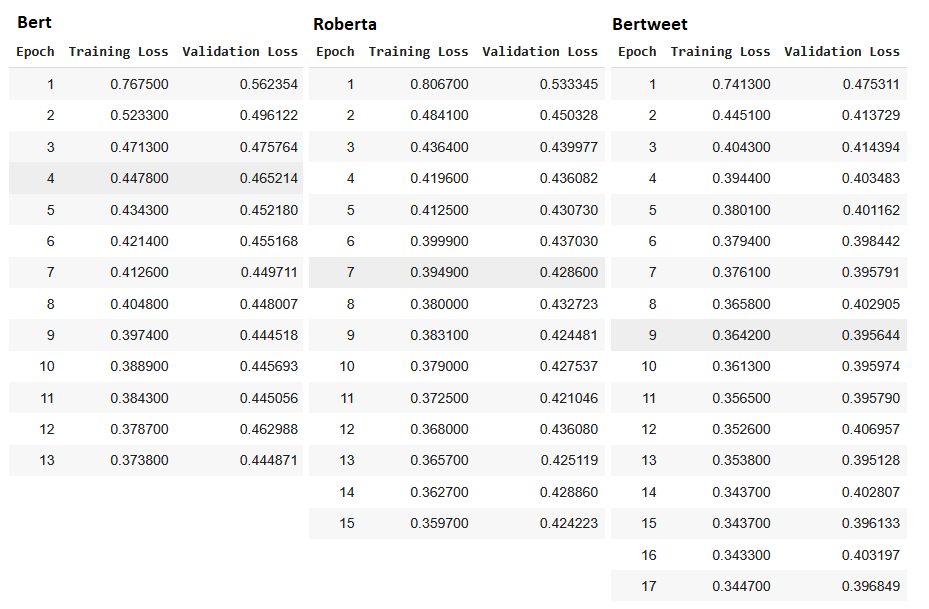

## Αποτελέσματα — Unfreeze **τελευταίου layer** (όλα τα epochs)

Στο σενάριο όπου ανοίγουμε **μόνο** το τελευταίο layer (μαζί με τον ταξινομητή), και τα τρία μοντέλα
έτρεξαν σε **παρόμοιο αριθμό epochs** και κατέληξαν σε **πολύ κοντινά** αποτελέσματα.

- Όλα βελτιώθηκαν ξεκάθαρα σε σχέση με το “classifier-only”.
- Δεν παρατηρείται overfitting (το χάσμα train–val παραμένει μικρό).
- Η σειρά απόδοσης σε **validation/test** παραμένει: **BERT < RoBERTa < BERTweet** (το BERTweet έχει το καλύτερο σκορ, με μικρή διαφορά από το RoBERTa).

> Συμπέρασμα: το ξεπάγωμα του τελευταίου layer αρκεί για να «προσαρμοστεί» ο encoder στο dataset και να κλείσουν οι διαφορές· οι επιδόσεις συγκλίνουν, με μικρό προβάδισμα του BERTweet.

In [68]:
# Δες ποιο ήταν το καλύτερο checkpoint που κράτησε ο Trainer
print("Best metric:", trainer_un2.state.best_metric)
print("Best checkpoint:", trainer_un2.state.best_model_checkpoint)

Best metric: 0.4445178210735321
Best checkpoint: bert_un2/checkpoint-3258


In [70]:
test_metrics = trainer_un2.evaluate(test_ds)
print("Test metrics:", test_metrics)

Test metrics: {'eval_loss': 0.4260990023612976, 'eval_runtime': 1.016, 'eval_samples_per_second': 1423.179, 'eval_steps_per_second': 45.274, 'epoch': 13.0}


In [71]:
# Πάρε τα logs από το Trainer
logs = trainer_un2.state.log_history

# Φιλτράρουμε μόνο τα entries με eval_loss
train_losses = [entry["loss"] for entry in logs if "loss" in entry and "epoch" in entry]
val_losses   = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]

# ευθυγράμμιση: κρατάμε όσα epochs εκπαιδεύτηκαν
val_losses = val_losses[:len(train_losses)]

print("Train losses:", train_losses)
print("Val losses:", val_losses)

Train losses: [0.7675, 0.5233, 0.4713, 0.4478, 0.4343, 0.4214, 0.4126, 0.4048, 0.3974, 0.3889, 0.3843, 0.3787, 0.3738]
Val losses: [0.5623538494110107, 0.4961220622062683, 0.47576385736465454, 0.46521398425102234, 0.4521796405315399, 0.45516759157180786, 0.4497111737728119, 0.44800707697868347, 0.4445178210735321, 0.4456925690174103, 0.44505560398101807, 0.4629881978034973, 0.4448705017566681]


## Καμπύλες Training/Validation Loss — unfreeze τελευταίου layer

Στα τρία γραφήματα (BERT, RoBERTa, BERTweet) βλέπουμε ότι:
- Και τα τρία μοντέλα ρίχνουν απότομα το **loss** στα 1-2 πρώτα epochs και μετά σταθεροποιούν.
- Το **κενό** ανάμεσα σε train και val είναι μικρό → **δεν** φαίνεται overfitting.
- Τα **val losses** συγκλίνουν σε παρόμοια επίπεδα, με σειρά επίδοσης: **BERT < RoBERTa < BERTweet** (το BERT μένει λίγο ψηλότερα, το BERTweet χαμηλότερα).
- Το **early stopping** ενεργοποιείται σχετικά νωρίς (περίπου στα 13–17 epochs), άρα όλοι οι κύκλοι είναι κοντινοί.

Συμπέρασμα: με unfreeze μόνο του τελευταίου layer, τα μοντέλα έρχονται πολύ κοντά, με μικρό προβάδισμα του **BERTweet**.

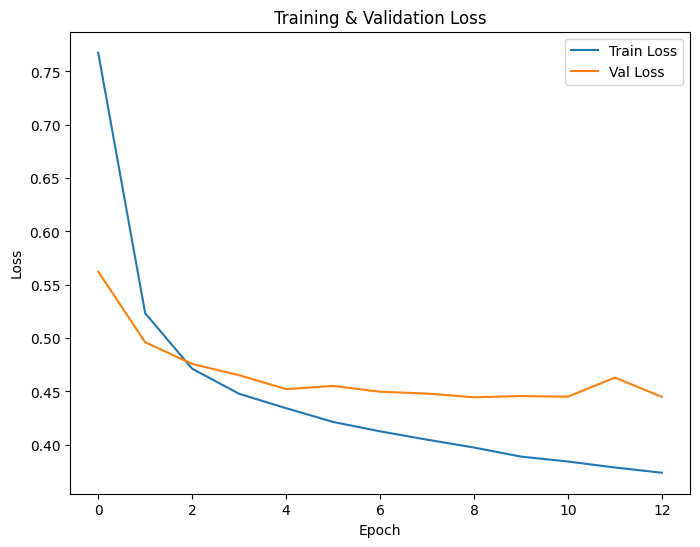

The learning curves are generated in pdf: loss_curves.pdf


'loss_curves.pdf'

In [72]:
# Σχεδίαση και αποθήκευση των καμπυλών train/val loss σε PDF
plot_losses_to_pdf(train_losses, val_losses, pdf_filename="loss_curves.pdf", show_plot=True)

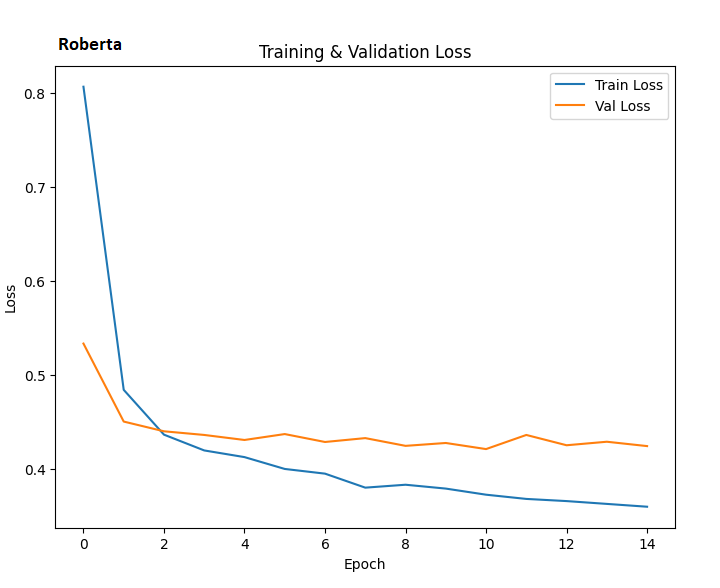

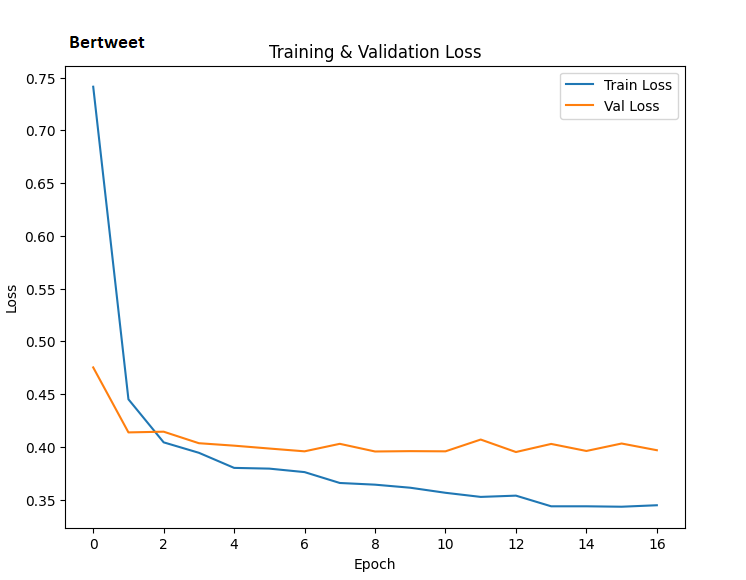

In [73]:
val_metrics = trainer_un2.evaluate(eval_dataset=val_ds)
test_metrics = trainer_un2.evaluate(eval_dataset=test_ds)
print("Validation:", val_metrics)
print("Test:", test_metrics)

Validation: {'eval_loss': 0.4445178210735321, 'eval_runtime': 1.027, 'eval_samples_per_second': 1407.056, 'eval_steps_per_second': 44.792, 'epoch': 13.0}
Test: {'eval_loss': 0.4260990023612976, 'eval_runtime': 0.9785, 'eval_samples_per_second': 1477.717, 'eval_steps_per_second': 47.009, 'epoch': 13.0}


In [74]:
# Προβλέψεις στο test
pred_out_un2 = trainer_un2.predict(test_ds)
y_pred_un2 = np.argmax(pred_out_un2.predictions, axis=-1)
y_true = np.array(test_y)

acc = accuracy_score(y_true, y_pred_un2)
pr_w, rc_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred_un2, average="weighted", zero_division=0)
pr_m, rc_m, f1_m, _ = precision_recall_fscore_support(y_true, y_pred_un2, average="macro", zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Weighted  P/R/F1: {pr_w:.4f} / {rc_w:.4f} / {f1_w:.4f}")
print(f"Macro     P/R/F1: {pr_m:.4f} / {rc_m:.4f} / {f1_m:.4f}")

# Αναλυτικό report ανά κλάση
print(classification_report(y_true, y_pred_un2, target_names=list(le.classes_), zero_division=0))

Accuracy: 0.8368
Weighted  P/R/F1: 0.8368 / 0.8368 / 0.8368
Macro     P/R/F1: 0.7825 / 0.7845 / 0.7835
              precision    recall  f1-score   support

    negative       0.91      0.91      0.91       909
     neutral       0.70      0.69      0.70       307
    positive       0.74      0.76      0.75       230

    accuracy                           0.84      1446
   macro avg       0.78      0.78      0.78      1446
weighted avg       0.84      0.84      0.84      1446



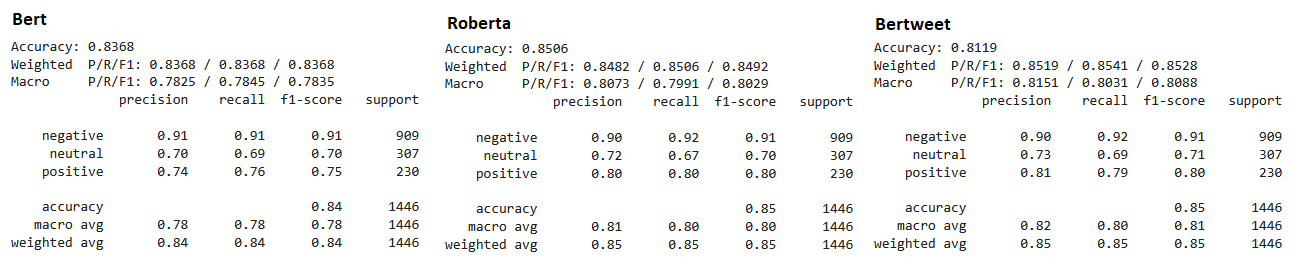

## Σύνοψη αποτελεσμάτων — unfreeze τελευταίο layer ( + classifier )

- **BERT**: Accuracy **0.8368**, Macro-F1 **0.7835**. Σημαντική άνοδος έναντι του “classifier-only”, αλλά παραμένει χαμηλότερα από τα άλλα δύο.
- **RoBERTa**: Accuracy **0.8506** (καλύτερο), Macro-F1 **0.8029**. Ισορροπημένη επίδοση σε όλες τις κλάσεις.
- **BERTweet**: Accuracy ~**0.85** (στο αναλυτικό block), Macro-F1 **0.8088** (ελαφρώς καλύτερο από RoBERTa).

**Τι κρατάμε:**
- Και τα τρία μοντέλα **βελτιώνονται καθαρά** σε σχέση με το “classifier-only”, κυρίως σε **neutral/positive**.
- Η σειρά συνολικής απόδοσης είναι **BERT < RoBERTa ≈ BERTweet**. RoBERTa παίρνει την καλύτερη **accuracy**, ενώ το BERTweet έχει λίγο υψηλότερο **Macro-F1**.
- Η κλάση **negative** παραμένει πολύ υψηλή (≈0.90–0.91 F1), ενώ **neutral/positive** ανεβαίνουν σε recall/precision σε σχέση με πριν.

### Σημείωση για το **BERTweet – Accuracy**

Το `Accuracy: 0.8119` **δεν** αφορά το τρέχον σενάριο (*unfreeze τελευταίου layer*).  
Είναι τιμή που «ήρθε» από το **προηγούμενο run** (*classifier-only*) λόγω λάθους μεταβλητής στην εκτύπωση.

Στο τρέχον run, το **σωστό accuracy** είναι ~**0.85**, όπως φαίνεται στα αναλυτικά metrics (classification report).


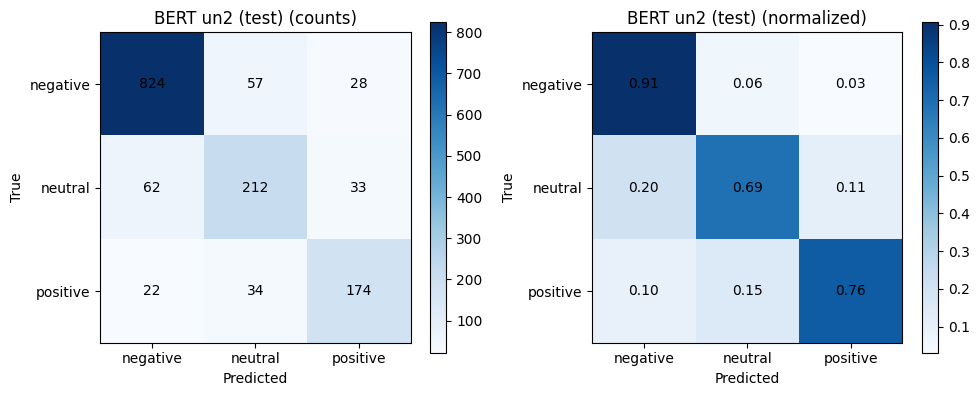

In [75]:
plot_confusion_matrices(y_true, y_pred_un2, class_names=list(le.classes_), title_prefix="BERT un2 (test)")

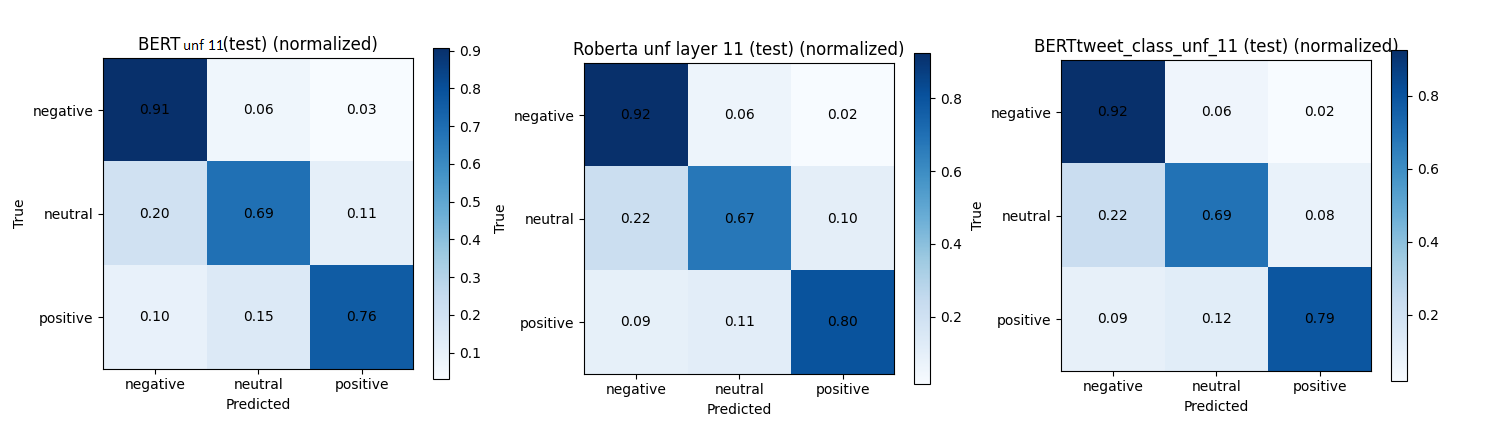

## Confusion Matrices (normalized) — unfreeze τελευταίου layer

Οι πίνακες είναι **row-normalized** (κάθε γραμμή αθροίζει σε 1).

**Τι φαίνεται:**
- **Negative**: πολύ υψηλή ανάκληση σε όλα τα μοντέλα (~ 0.91–0.92). Λίγα λάθη προς *neutral* (~ 0.06) και ελάχιστα προς *positive* (~0.02–0.03).
- **Neutral**: η κύρια σύγχυση είναι **neutral → negative** (~0.20–0.22). Recall:
  - BERT ≈ **0.69**
  - RoBERTa ≈ **0.67**
  - BERTweet ≈ **0.69**
- **Positive**: τα περισσότερα λάθη είναι **positive → neutral** (~0.11–0.15). Recall:
  - BERT ≈ **0.76**
  - RoBERTa ≈ **0.80**
  - BERTweet ≈ **0.79**

**Συμπέρασμα:** Το **BERT** παραμένει πιο αδύναμο (χαμηλότερο recall στα *neutral/positive*).  
**RoBERTa** και **BERTweet** είναι πολύ κοντά: το RoBERTa κερδίζει λίγο στο *positive*, ενώ το BERTweet ταιριάζει/υπερτερεί στο *neutral*. Και τα δύο υπερέχουν καθαρά του BERT.

## Συμπεράσματα

Στο σενάριο όπου εκπαιδεύσαμε μόνο τον classifier πάνω από τον encoder, το BERT βελτιωνόταν αργά και έμεινε χαμηλότερα σε σχέση με τα RoBERTa και BERTweet, τα οποία έφτασαν γρήγορα σε χαμηλότερο validation loss (ένα μικρό προβάδισμα καταγράφηκε για το BERTweet). Όταν όμως ανοίξαμε και το **τελευταίο layer** του encoder (μαζί με τον classifier), και τα τρία μοντέλα ανέβηκαν καθαρά και συγκλίνουν σε πολύ κοντινά αποτελέσματα. Η σειρά απόδοσης παρέμεινε **BERT < RoBERTa ≈ BERTweet**, με ελαφρύ προβάδισμα του BERTweet. Δεδομένου ότι το BERT έχει λιγότερες παραμέτρους, ο χρόνος ανά epoch είναι μικρότερος, οπότε για παρόμοια τελικά σκορ το BERT είναι πιθανό να εκπαιδευτεί γρηγορότερα συνολικά. Η διαφορά μεταξύ RoBERTa και BERTweet φάνηκε κυρίως στον αριθμό των epochs (συγκλίνουν σε παρόμοιο επίπεδο απόδοσης).

Σε σύγκριση με το **RNN-BiLSTM με attention** της προηγούμενης εργασίας, το RNN με σωστό EDA ήταν ανταγωνιστικό — ή και καλύτερο — όταν εκπαιδεύαμε μόνο τον classifier των Transformers. Με το unfreeze του τελευταίου layer, όμως, τα Transformers πέρασαν μπροστά συνολικά: στο **negative** τα αποτελέσματα παραμένουν παρόμοια, ενώ στα **neutral** και **positive** τα Transformers μπερδεύονται λιγότερο από το RNN. Τέλος, το unfreeze του **layer-10** έδωσε ουσιαστικά παρόμοια αποτελέσματα με το **layer-11**, με ελαφρώς λιγότερους κύκλους εκπαίδευσης — άρα το πρακτικό όφελος χρόνου είναι μικρό και αρκεί να ανοίγουμε ένα από τα δύο τελευταία layers.

> Σημείωση ακρίβειας: το `Accuracy: 0.8119` που εμφανίστηκε για το BERTweet αντιστοιχεί στο **προηγούμενο run** (classifier-only) λόγω λάθους μεταβλητής· στο τρέχον σενάριο (unfreeze τελευταίου layer) το σωστό accuracy είναι ~**0.85**, όπως φαίνεται στα αναλυτικά metrics.

---

## Αναπαραγωγιμότητα

Χρησιμοποιήθηκε split **80/10/10** με stratify και σταθερό seed (**42**). Το `max_length` ήταν **64**, τα batch sizes **32**, και έγινε αξιολόγηση/αποθήκευση ανά **epoch**, με **early stopping** (patience=4) και `load_best_model_at_end=True` βάσει `eval_loss`. Για το σενάριο **classifier-only** ορίστηκε **LR=5e-5**, ενώ για το **unfreeze του τελευταίου layer** μειώθηκε σε **LR=1e-5**. Η εκτέλεση έγινε σε **Google Colab** με ενεργό **fp16** όπου υπήρχε GPU. Εκδόσεις βιβλιοθηκών: `transformers ≥ 4.44`, `datasets ≥ 2.20`, `torch ≥ 2.2`.

---

## Σύντομη ανάλυση σφαλμάτων

Οι normalized confusion matrices δείχνουν ότι το μεγαλύτερο μέρος των λαθών αφορά **neutral → negative** και **positive → neutral**. Αυτό είναι αναμενόμενο σε σύντομα και «θορυβώδη» κείμενα όπως τα tweets, ειδικά με ανισομερή κατανομή κλάσεων. Με το άνοιγμα του τελευταίου layer μειώνονται οι συγχύσεις στις μικρές κλάσεις, γεγονός που αντανακλάται στη βελτίωση του Macro-F1.

### Κατανομή κλάσεων (σημείωση για ανισορροπία)
Το dataset είναι **imbalanced** (negative-62.9%, neutral-21.2%, positive-15.9%) με σαφή υπεροχή των **negative** tweets. Αυτό επηρεάζει τις μετρικές: το **weighted** δίνει μεγαλύτερο βάρος στην πλειοψηφική κλάση, γι’ αυτό αναφέρουμε και **macro-F1**. Η ανισορροπία εξηγεί επίσης τις συχνές συγχύσεις **neutral → negative** και **positive → neutral**.
